<div>
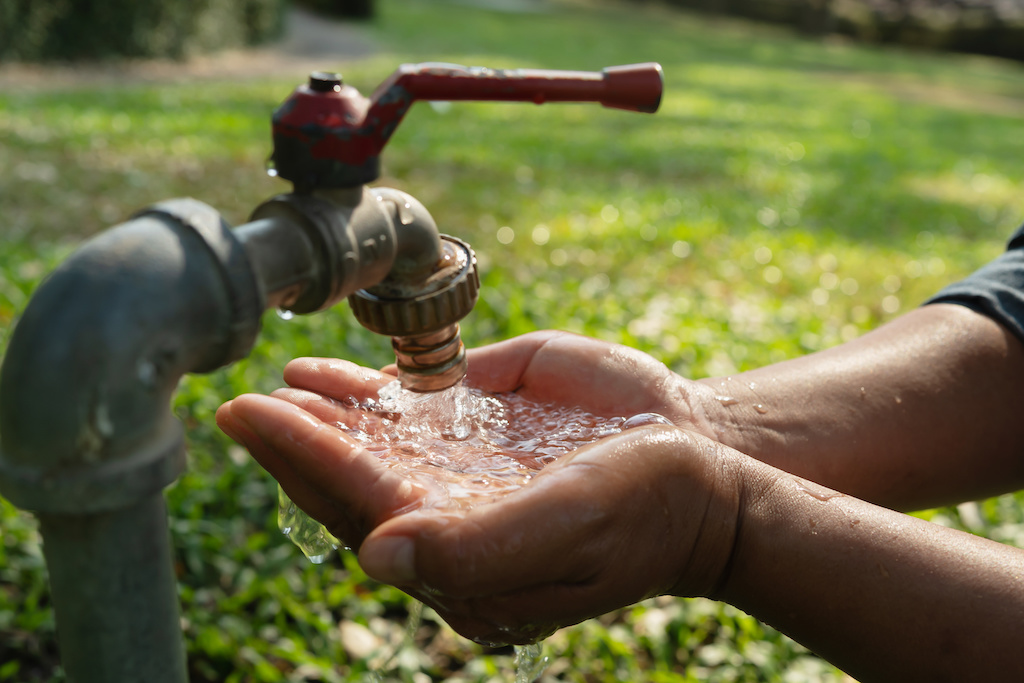
</div>
Photo by <a href="https://stock.adobe.com/contributor/203603884/lovelyday12?load_type=author&prev_url=detail" >lovelyday12</a> on Adobe Stock

# Phase 3 Project: *Tanzanian Water Pump Conditions Classification Model*

### By Ryan Posternak

Flatiron School, Full-time Live NYC<br>
Project Presentation Date: July 15th, 2022<br>
Instructor: Joseph Mata

## Goal: Identify which water pumps in Tanzania are functional, functional but in need of repair, or non-functional based on a variety of conditions and information on the pump 

<br>

# Overview and Business Understanding

<br>

# Data Understanding

<br>

# Initial EDA

### Description of columns

**amount_tsh** - Total static head (amount water available to waterpoint)<br>
**date_recorded** - The date the row was entered<br>
**funder** - Who funded the well<br>
**gps_height** - Altitude of the well<br>
**installer** - Organization that installed the well<br>
**longitude** - GPS coordinate<br>
**latitude** - GPS coordinate<br>
**wpt_name** - Name of the waterpoint if there is one<br>
**basin** - Geographic water basin<br>
**subvillage** - Geographic location<br>
**region** - Geographic location<br>
**region_code** - Geographic location (coded)<br>
**district_code** - Geographic location (coded)<br>
**lga** - Geographic location<br>
**ward** - Geographic location<br>
**population** - Population around the well<br>
**public_meeting** - True/False<br>
**recorded_by** - Group entering this row of data<br>
**scheme_management** - Who operates the waterpoint<br>
**scheme_name** - Who operates the waterpoint<br>
**permit** - If the waterpoint is permitted<br>
**construction_year** - Year the waterpoint was constructed<br>
**extraction_type** - The kind of extraction the waterpoint uses<br>
**extraction_type_group** - The kind of extraction the waterpoint uses<br>
**extraction_type_class** - The kind of extraction the waterpoint uses<br>
**management** - How the waterpoint is managed<br>
**management_group** - How the waterpoint is managed<br>
**payment** - What the water costs<br>
**payment_type** - What the water costs<br>
**water_quality** - The quality of the water<br>
**quality_group** - The quality of the water<br>
**quantity** - The quantity of water<br>
**quantity_group** - The quantity of water<br>
**source** - The source of the water<br>
**source_type** - The source of the water<br>
**source_class** - The source of the water<br>
**waterpoint_type** - The kind of waterpoint<br>
**waterpoint_type_group** - The kind of waterpoint<br>
<br>

### Description of labels

**functional** - the waterpoint is operational and there are no repairs needed<br>
**functional needs repair** - the waterpoint is operational, but needs repairs<br>
**non functional** - the waterpoint is not operational

In [99]:
import numpy as np
import pandas as pd

import folium

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
confusion_matrix, plot_confusion_matrix

from sklearn import set_config
set_config(display='diagram')

import warnings
from sklearn.exceptions import UndefinedMetricWarning, ConvergenceWarning
from sklearn.utils._testing import ignore_warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Load up the data

# Submission format example for competition
submission_format_df = pd.read_csv('data/Pump_it_Up_Data_Mining_the_Water_Table_-_Submission_format.csv')

# Load in X_train dataframe
X_train_df = pd.read_csv('data/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv')

# Load in y_train dataframe
y_train_df = pd.read_csv('data/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv')

# Load in X_test dataframe (for competition purposes only - will not be used as X_test dataframe for 
# train/test split purposes as labels were not included)
X_test_df = pd.read_csv('data/Pump_it_Up_Data_Mining_the_Water_Table_-_Test_set_values.csv')

In [3]:
# Preview features dataframe

print(X_train_df.shape)
X_train_df.head()

(59400, 40)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
# Preview target variables dataframe

y_train_df.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [5]:
# Preview distribution of target variables

print(y_train_df['status_group'].value_counts(), '\n')
print(y_train_df['status_group'].value_counts(normalize=True))

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64 

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64


> **Remarks:**
> - The dataset is somewhat imbalanced, with 54% in the 'functional' group, 38% in the 'non functional' group, and the remaining 7% in the 'functional needs repair' group

In [6]:
# Preview features dataframe info

X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

> **Remarks:**
> - 7 int features, 3 float features, 30 object features
> - Most features are nominal categorical descriptors, with many of the numerical descriptors actually being location identification variables
> - Some features with a lot of missing values: scheme_name, funder, installer, scheme_management


In [7]:
columns_isna = [column for column in X_train_df.columns if X_train_df[column].isna().sum() > 0]
    
print('Features with missing values:')
X_train_df[columns_isna].isna().sum()

Features with missing values:


funder                3635
installer             3655
subvillage             371
public_meeting        3334
scheme_management     3877
scheme_name          28166
permit                3056
dtype: int64

In [8]:
y_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


> **Remarks:**
> - No missing `status_group` labels

In [9]:
X_train_df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [10]:
# Coordinates of Dodoma - capital of Tanzania
dodoma_lat = -6.1630
dodoma_long = 35.7516

# Create a map of the area
base_map = folium.Map([dodoma_lat, dodoma_long], zoom_start=5.5)

# Add random sample of 300 water pumps to map, colored by water pump condition
for index, pump in X_train_df.sample(n=300).iterrows():
    lat = pump.latitude
    long = pump.longitude
    if y_train_df.iloc[index].status_group == 'functional':
        color = 'green'
    elif y_train_df.iloc[index].status_group == 'functional needs repair':
        color = 'orange'
    elif y_train_df.iloc[index].status_group == 'non functional':
        color = 'red'
    marker = folium.Marker(location=[lat, long])
    marker.add_to(base_map)
    popup_text = f"Condition: {y_train_df.iloc[index].status_group.capitalize()}"
    popup = folium.Popup(popup_text, parse_html=True)
    marker = folium.Marker(location=[lat, long], popup=popup, icon=folium.Icon(color))
    marker.add_to(base_map)
base_map

# Preprocessing

### Drop `id` column of X_train and y_train

ID numbers are not necessary for modeling purposes (I am assuming they carry no predictive value)

In [11]:
X_train_df.drop(columns='id', inplace=True)

y_train_df.drop(columns='id', inplace=True)

### Convert `status_group` column of y_train from ternary object to binary int: 0 if 'functional', 1 if 'functional needs repair' or 'non functional'

To simplify the modeling process, we'll convert this from a multi-class classification problem to a binary classification: 0 if the pump is functional and 1 if the pump needs attention

In [12]:
y_train_df.replace({'functional': 0, 'functional needs repair': 1, 'non functional': 1}, inplace=True)

# Sanity check
y_train_df.value_counts()

status_group
0               32259
1               27141
dtype: int64

### Drop additional valueless variables:

1. **`funder` and `installer`** - Who funded the well<br>
While some value may be lost by dropping these features, they would be cumbersome to work with as they contain thousands of unique values, and many of the values have only one corresponding row.

2. **`date_recorded`** - The date the row was entered<br>
Unlikely to carry any predictive value - date of construction is already captured in `construction_year`<br>

3. **`longitude`** and **`latitude`** - GPS coordinates<br>
Such specific location information is unlikely to carry much predictive value, and substantial location information is already captured in other columns<br>

4. **`num_private`** - Undisclosed<br>
It is undisclosed what this feature means, but 58,643 of the 59,400 rows all contain '0' for this feature and many of the values of the feature have only one corresponding row, so it would be cumbersome to work with and is unlikely to carry any predictive value anyway

5. **`region`** - Geographic location<br>
Essentially the same information as `region_code` column, but with what appears to be slighly less granularity. Since `region_code` contains more granularity, we'll keep that one

6. **`wpt_name`** - Name of the waterpoint if there is one<br>
Unlikely to carry much predictive value — most of the values for this feature are unique to one row or 'none', and substantial waterpoint information is captured in other variables

7. **`subvillage`** - Geographic location<br>
May potentially carry some predictive value, however substantial location information is already contained in other columns, and numerous subvillages exist with only a single row which would be tricky to deal with while modeling. Additionally, 371 missing values exist for this column.

8. **`ward`** - Geographic location<br>
Contains over 2k unique values, many with only one corresponding row, which would be cumbersome to work with. Additionally, location information is captured in other variables.

9. **`recorded_by`** - Group entering this row of data<br>
All rows have same value for this feature: 'GeoData Consultants Ltd'

10. **`scheme_management`** and **`management_group`**- Who operates the waterpoint / How the waterpoint is managed<br>
All three columns below contain essentially the same information, with variations on the level of granularity. Since `management` contains more granular information than `management_group` and is missing fewer values than `scheme_management`, we'll keep that one.

11. **`scheme_name`** - Who operates the waterpoint<br>
Feature contains 28,166 missing values, plus 664 where the value is equal to 'None'. Additionally, many of the values for this feature have only one corresponding row, and information on the operator is also captured in the `management` feature which has no missing values. As such, we'll drop this feature, though there may be a small amount of predictive value in it.

12. **`extraction_type_group`** and **`extraction_type_class`** - The kind of extraction the waterpoint uses<br>
All three columns below contain essentially the same information, with variations on the level of granularity. Since `extraction_type` contains the most granular information, we'll keep that one.

13. **`payment`** - What the water costs<br>
Exact duplicate of information in column `payment_type`

14. **`quality_group`** - The quality of the water<br>
Essentially the same information as `water_quality` column, with less granularity. Since `water_quality` contains more granularity, we'll keep that one.

15. **`quantity_group`** - The quantity of water<br>
Exact duplicate of information in column `quantity`

16. **`source_type`** and **`source_class`** - The source of the water<br>
All three columns below contain essentially the same information, with variations on the level of granularity. Since `source` contains the most granular information, we'll keep that one.

17. **`waterpoint_type_group`** - The kind of waterpoint<br>
Essentially the same information as `waterpoint_type` column, with less granularity. Since `waterpoint_type` contains more granularity, we'll keep that one.

In [13]:
columns_to_drop = ['funder', 'installer', 'date_recorded', 'longitude', 'latitude', 'num_private', 'region', 
                   'wpt_name', 'subvillage', 'ward', 'recorded_by', 'scheme_management', 'scheme_name', 
                   'extraction_type_group', 'extraction_type_class', 'management_group', 'payment', 
                   'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group']

X_train_df.drop(columns=columns_to_drop, inplace=True)

### Convert `region_code` and `district_code` to datatype 'object'

These features are actually nominal categorical features describing location, despite being in integer form. Converting them to datatype 'object' will make them easier to work with when it comes time to build the pipelines.

In [14]:
X_train_df['region_code'] = X_train_df['region_code'].astype('object')

X_train_df['district_code'] = X_train_df['district_code'].astype('object')

### Convert `public_meeting` and `permit` columns from object to int: 0 if 'False', 1 if 'True'

Converting these from boolean to int will help when one hot encoding

In [15]:
X_train_df['public_meeting'].replace({False: 0, True: 1}, inplace=True)

X_train_df['permit'].replace({False: 0, True: 1}, inplace=True)

In [16]:
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         59400 non-null  float64
 1   gps_height         59400 non-null  int64  
 2   basin              59400 non-null  object 
 3   region_code        59400 non-null  object 
 4   district_code      59400 non-null  object 
 5   lga                59400 non-null  object 
 6   population         59400 non-null  int64  
 7   public_meeting     56066 non-null  float64
 8   permit             56344 non-null  float64
 9   construction_year  59400 non-null  int64  
 10  extraction_type    59400 non-null  object 
 11  management         59400 non-null  object 
 12  payment_type       59400 non-null  object 
 13  water_quality      59400 non-null  object 
 14  quantity           59400 non-null  object 
 15  source             59400 non-null  object 
 16  waterpoint_type    594

In [17]:
X_train_df.head()

,amount_tsh,gps_height,basin,region_code,district_code,lga,population,public_meeting,permit,construction_year,extraction_type,management,payment_type,water_quality,quantity,source,waterpoint_type
0,6000.0,1390,Lake Nyasa,11,5,Ludewa,109,1.0,0.0,1999,gravity,vwc,annually,soft,enough,spring,communal standpipe
1,0.0,1399,Lake Victoria,20,2,Serengeti,280,NaN,1.0,2010,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe
2,25.0,686,Pangani,21,4,Simanjiro,250,1.0,1.0,2009,gravity,vwc,per bucket,soft,enough,dam,communal standpipe multiple
3,0.0,263,Ruvuma / Southern Coast,90,63,Nanyumbu,58,1.0,1.0,1986,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple
4,0.0,0,Lake Victoria,18,1,Karagwe,0,1.0,1.0,0,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe


# Train/Test Split

As we saw above, this is an unbalanced dataset, so we'll set stratify=y to ensure an even balance of labels between train and test sets. We'll keep that default test size of 0.25.

In [18]:
X = X_train_df.copy()
y = y_train_df.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [19]:
print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Testing set: {X_test.shape}, {y_test.shape}')
print()

# Check that target variables are evenly distributed between y_train and y_test
print(f'Training set: {y_train.value_counts(normalize=True)}')
print(f'Testing set: {y_test.value_counts(normalize=True)}')

Training set: (44550, 17), (44550, 1)
Testing set: (14850, 17), (14850, 1)

Training set: status_group
0               0.543075
1               0.456925
dtype: float64
Testing set: status_group
0               0.543098
1               0.456902
dtype: float64


# Define functions for cleaning pipeline

To streamline the process, we'll define functions that will go into the ColumnTransformer pipeline that will be applied to both the X_train and X_test sets

**Rundown:**
1. Handle missing values
 - Both features with missing values are binary categorical (boolean in integer form). We'll impute the most common value for NaN values with these.


### Handle missing values

These are the features that still have missing values after initial preprocessing

In [130]:
columns_isna = [column for column in X_train_df.columns if X_train_df[column].isna().sum() > 0]
    
print('Features with missing values:')
X_train_df[columns_isna].isna().sum()

Features with missing values:


public_meeting    3334
permit            3056
dtype: int64

In [21]:
def fill_nulls(df):
    """
    Fill null values in each column known to contain null 
    values with most common value: 1.0. If any rows with null 
    values remain, drop them.
    """
    df.fillna({"public_meeting": 1.0,
               "permit": 1.0,
              },
              inplace=True)
    df.dropna()
    return df

In [22]:
def imputer(df):
    """
    For construction_year column of df, impute the mean construction_year
    value where the value is currently equal to 0
    """
    df.loc[df['construction_year'] == 0, 'construction_year'] = \
    df.loc[df['construction_year'] != 0, 'construction_year'].mean()
    df['construction_year'] = df['construction_year'].astype('int')
    return df

In [75]:
X_train.columns

Index(['amount_tsh', 'gps_height', 'basin', 'region_code', 'district_code',
       'lga', 'population', 'public_meeting', 'permit', 'construction_year',
       'extraction_type', 'management', 'payment_type', 'water_quality',
       'quantity', 'source', 'waterpoint_type'],
      dtype='object')

In [23]:
# StandardScale numerical columns as part of cleaning
ss_cols = list(X_train.select_dtypes(['int', 'float']).columns)

# OneHotEncode categorical columns as part of cleaning
ohe_cols = list(X_train.select_dtypes('object').columns)

# Put both into ColumnTransformer object
transformer = ColumnTransformer(transformers=[
                                   ('standard_scale', StandardScaler(), ss_cols), 
                                   ('ohe', OneHotEncoder(drop='first', 
                                                        sparse=False, 
                                                        handle_unknown='ignore'), 
                                                        ohe_cols)], 
                                   remainder='passthrough')

# Create cleaning_pipeline with transformer and custom functions defined above
cleaning_pipeline = Pipeline(steps=[
    ('fill_nulls', FunctionTransformer(fill_nulls)), 
    ('impute', FunctionTransformer(imputer)), 
    ('transform', transformer)
])

In [24]:
pd.DataFrame(cleaning_pipeline.fit_transform(X_train))

,0,1,2,3,4,5,6,7,8,9,...,232,233,234,235,236,237,238,239,240,241
0,0.053824,0.235072,0.145821,0.305547,-1.548853,0.543503,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.095549,1.116471,0.880097,0.305547,0.645639,0.145586,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.098598,1.067344,0.670304,0.305547,-1.548853,1.140380,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.098598,-0.965653,-0.378662,0.305547,0.645639,-0.053373,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.206245,1.551391,-0.294745,0.305547,-1.548853,-0.849208,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44545,-0.083356,-0.887627,5.915132,-3.272821,-1.548853,0.543503,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
44546,-0.098598,1.544166,-0.376564,0.305547,0.645639,1.140380,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
44547,-0.098598,-0.965653,-0.378662,0.305547,0.645639,-0.053373,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
44548,-0.095549,-0.329890,-0.294745,0.305547,0.645639,1.140380,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [25]:
cleaning_pipeline

Pipeline(steps=[('fill_nulls',
                 FunctionTransformer(func=<function fill_nulls at 0x7fbd545e1ca0>)),
                ('impute',
                 FunctionTransformer(func=<function imputer at 0x7fbd545e1f70>)),
                ('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standard_scale',
                                                  StandardScaler(),
                                                  ['amount_tsh', 'gps_height',
                                                   'population',
                                                   'public_meeting', 'permit',
                                                   'construction_year']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['basin', 'region_code',
                                                   'district_code', 'lga',
                                                   'extraction_type',
                                                   'management', 'payment_type',
                                                   'water_quality', 'quantity',
                                                   'source',
                                                   'waterpoint_type'])]))])

In [26]:
def print_cv_scores(pipe, X, y):
    '''
    Runs cross_validate on given feature and multiclass target arrays using given pipeline
    and prints the training and cross_val scores
    '''
    scoring = ['accuracy','precision', 'recall', 'f1']
    # pass in pipe to cross validate along with a feature list
    results = cross_validate(pipe, X, y, return_train_score=True, scoring=scoring)
    
    print('Training Accuracy', results['train_accuracy'].mean())
    print('Cross_Val Accuracy', results['test_accuracy'].mean())
    print('-'*50)
    print('Training Precision:', results['train_precision'].mean())
    print('Cross_Val Precision:', results['test_precision'].mean())
    print('-'*50)
    print('Training Recall:', results['train_recall'].mean())
    print('Cross_Val Recall:', results['test_recall'].mean())
    print('-'*50)
    print('Training F1:', results['train_f1'].mean())
    print('Cross_Val F1:', results['test_f1'].mean())

# Baseline: Dummy Classifier

In [27]:
steps=[('preprocessing', cleaning_pipeline), 
       ('dc', DummyClassifier(strategy='most_frequent'))]

dummy_pipe = Pipeline(steps)

dummy_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('fill_nulls',
                                  FunctionTransformer(func=<function fill_nulls at 0x7fbd545e1ca0>)),
                                 ('impute',
                                  FunctionTransformer(func=<function imputer at 0x7fbd545e1f70>)),
                                 ('transform',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('standard_scale',
                                                                   StandardScaler(),
                                                                   ['amount_tsh',
                                                                    'gps_height',
                                                                    'population',
                                                                    'public_meeting',
                                                                    'permit',
                                                                    'construction_year']),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['basin',
                                                                    'region_code',
                                                                    'district_code',
                                                                    'lga',
                                                                    'extraction_type',
                                                                    'management',
                                                                    'payment_type',
                                                                    'water_quality',
                                                                    'quantity',
                                                                    'source',
                                                                    'waterpoint_type'])]))])),
                ('dc', DummyClassifier(strategy='most_frequent'))])

In [36]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UndefinedMetricWarning)
    print_cv_scores(dummy_pipe, X_train, y_train)

/Users/ryanposternak/opt/anaconda3/envs/new-learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Training Accuracy 0.5430751964085297
Cross_Val Accuracy 0.5430751964085297
--------------------------------------------------
Training Precision: 0.0
Cross_Val Precision: 0.0
--------------------------------------------------
Training Recall: 0.0
Cross_Val Recall: 0.0
--------------------------------------------------
Training F1: 0.0
Cross_Val F1: 0.0


/Users/ryanposternak/opt/anaconda3/envs/new-learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


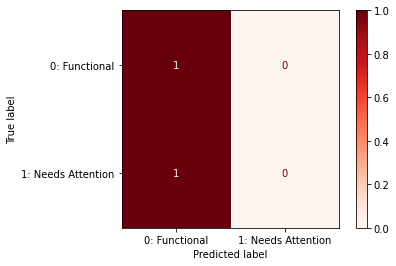

In [46]:
class_names = ['0: Functional', '1: Needs Attention']
plot_confusion_matrix(dummy_pipe, X_train, y_train, normalize='true', display_labels=class_names, cmap='Reds');

# Model 1.1: Logistic Regression, Iteration 1

In [30]:
steps=[('preprocessing', cleaning_pipeline), 
       ('logreg', LogisticRegression(random_state=42))]

lr_1_pipe = Pipeline(steps)

lr_1_pipe.fit(X_train, y_train.values.ravel())

/Users/ryanposternak/opt/anaconda3/envs/new-learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('fill_nulls',
                                  FunctionTransformer(func=<function fill_nulls at 0x7fbd545e1ca0>)),
                                 ('impute',
                                  FunctionTransformer(func=<function imputer at 0x7fbd545e1f70>)),
                                 ('transform',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('standard_scale',
                                                                   StandardScaler(),
                                                                   ['amount_tsh',
                                                                    'gps_height',
                                                                    'population',
                                                                    'public_meeting',
                                                                    'permit',
                                                                    'construction_year']),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['basin',
                                                                    'region_code',
                                                                    'district_code',
                                                                    'lga',
                                                                    'extraction_type',
                                                                    'management',
                                                                    'payment_type',
                                                                    'water_quality',
                                                                    'quantity',
                                                                    'source',
                                                                    'waterpoint_type'])]))])),
                ('logreg', LogisticRegression(random_state=42))])

In [31]:
with ignore_warnings(category=ConvergenceWarning):
    print_cv_scores(lr_1_pipe, X_train, y_train.values.ravel())

/Users/ryanposternak/opt/anaconda3/envs/new-learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Training Accuracy 0.7702525252525252
Cross_Val Accuracy 0.7669135802469136
--------------------------------------------------
Training Precision: 0.7933327440386886
Cross_Val Precision: 0.7893731215059776
--------------------------------------------------
Training Recall: 0.6723324574917415
Cross_Val Recall: 0.6681571192859166
--------------------------------------------------
Training F1: 0.7278354467392816
Cross_Val F1: 0.7237177345092506


/Users/ryanposternak/opt/anaconda3/envs/new-learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


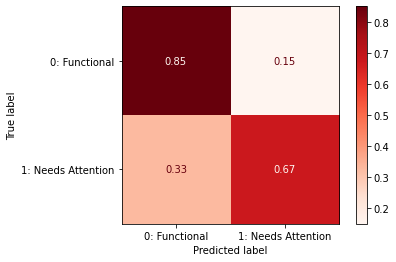

In [47]:
plot_confusion_matrix(lr_1_pipe, X_train, y_train, normalize='true', display_labels=class_names, cmap='Reds');

# Model 1.2: Logistic Regression, Iteration 2

Run the same LR model as before, but with balanced class weights

In [33]:
steps=[('preprocessing', cleaning_pipeline), 
       ('logreg', LogisticRegression(class_weight='balanced', random_state=42))]

lr_2_pipe = Pipeline(steps)

lr_2_pipe.fit(X_train, y_train.values.ravel())

/Users/ryanposternak/opt/anaconda3/envs/new-learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('fill_nulls',
                                  FunctionTransformer(func=<function fill_nulls at 0x7fbd545e1ca0>)),
                                 ('impute',
                                  FunctionTransformer(func=<function imputer at 0x7fbd545e1f70>)),
                                 ('transform',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('standard_scale',
                                                                   StandardScaler(),
                                                                   ['amount_tsh',
                                                                    'gps_height',
                                                                    'population',
                                                                    'public_meeting',
                                                                    'permit',
                                                                    'construction_year']),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['basin',
                                                                    'region_code',
                                                                    'district_code',
                                                                    'lga',
                                                                    'extraction_type',
                                                                    'management',
                                                                    'payment_type',
                                                                    'water_quality',
                                                                    'quantity',
                                                                    'source',
                                                                    'waterpoint_type'])]))])),
                ('logreg',
                 LogisticRegression(class_weight='balanced', random_state=42))])

In [35]:
with ignore_warnings(category=ConvergenceWarning):
    print_cv_scores(lr_2_pipe, X_train, y_train.values.ravel())

/Users/ryanposternak/opt/anaconda3/envs/new-learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Training Accuracy 0.76831088664422
Cross_Val Accuracy 0.7644893378226711
--------------------------------------------------
Training Precision: 0.763134817767641
Cross_Val Precision: 0.7584676217936583
--------------------------------------------------
Training Recall: 0.7148015411433244
Cross_Val Recall: 0.7109451875573984
--------------------------------------------------
Training F1: 0.73817607695618
Cross_Val F1: 0.733925379681784


/Users/ryanposternak/opt/anaconda3/envs/new-learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


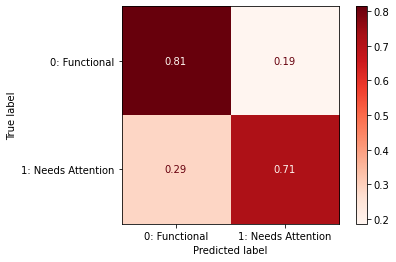

In [48]:
plot_confusion_matrix(lr_2_pipe, X_train, y_train, display_labels=class_names, normalize='true', cmap='Reds');

# Model 1.3: Logistic Regression, Iteration 3

With GridSearchCV

In [91]:
steps=[('preprocessing', cleaning_pipeline), 
       ('logreg', LogisticRegression(random_state=42))]

lr_3_pipe = Pipeline(steps)

pipe_grid = {'logreg__C': [1, 10, 20], 
             'logreg__max_iter': [100, 500]}

lr_3_gs_pipe = GridSearchCV(estimator=lr_3_pipe, 
                            param_grid=pipe_grid, 
                            cv=3)

In [92]:
with ignore_warnings(category=ConvergenceWarning):
    lr_3_gs_pipe.fit(X_train, y_train.values.ravel())

/Users/ryanposternak/opt/anaconda3/envs/new-learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/ryanposternak/opt/anaconda3/envs/new-learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/ryanposternak/opt/anaconda3/envs/new-learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/ryanposternak/opt/anaconda3/envs/new-learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1, 4] during transform. The

In [93]:
lr_3_gs_pipe.best_params_

{'logreg__C': 10, 'logreg__max_iter': 100}

In [94]:
with ignore_warnings(category=ConvergenceWarning):
    lr_3_gs_pipe.fit(X_train, y_train.values.ravel())

/Users/ryanposternak/opt/anaconda3/envs/new-learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/ryanposternak/opt/anaconda3/envs/new-learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/ryanposternak/opt/anaconda3/envs/new-learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/ryanposternak/opt/anaconda3/envs/new-learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1, 4] during transform. The

In [95]:
pd.DataFrame(lr_3_gs_pipe.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__C,param_logreg__max_iter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.711113,0.058045,0.058571,0.002641,1,100,"{'logreg__C': 1, 'logreg__max_iter': 100}",0.763838,0.767946,0.768148,0.766644,0.001986,6
1,1.525841,0.107020,0.059641,0.002024,1,500,"{'logreg__C': 1, 'logreg__max_iter': 500}",0.764579,0.768081,0.768552,0.767071,0.001772,5
2,0.639358,0.013513,0.058767,0.002396,10,100,"{'logreg__C': 10, 'logreg__max_iter': 100}",0.764512,0.768350,0.770034,0.767632,0.002311,1
3,2.532843,0.079106,0.059827,0.004089,10,500,"{'logreg__C': 10, 'logreg__max_iter': 500}",0.763434,0.768485,0.769360,0.767093,0.002612,4
4,0.622663,0.050940,0.060877,0.004755,20,100,"{'logreg__C': 20, 'logreg__max_iter': 100}",0.764108,0.768148,0.769428,0.767228,0.002267,3
5,2.607327,0.161785,0.059363,0.001596,20,500,"{'logreg__C': 20, 'logreg__max_iter': 500}",0.763434,0.768754,0.769562,0.767250,0.002718,2


In [96]:
steps=[('preprocessing', cleaning_pipeline), 
       ('logreg', LogisticRegression(class_weight='balanced', C=10, random_state=42))]

lr_3_pipe = Pipeline(steps)

lr_3_pipe.fit(X_train, y_train.values.ravel())

/Users/ryanposternak/opt/anaconda3/envs/new-learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('fill_nulls',
                                  FunctionTransformer(func=<function fill_nulls at 0x7fbd545e1ca0>)),
                                 ('impute',
                                  FunctionTransformer(func=<function imputer at 0x7fbd545e1f70>)),
                                 ('transform',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('standard_scale',
                                                                   StandardScaler(),
                                                                   ['amount_tsh',
                                                                    'gps_height',
                                                                    'population',
                                                                    'public_meeting',
                                                                    'permit',
                                                                    'construction_year']),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['basin',
                                                                    'region_code',
                                                                    'district_code',
                                                                    'lga',
                                                                    'extraction_type',
                                                                    'management',
                                                                    'payment_type',
                                                                    'water_quality',
                                                                    'quantity',
                                                                    'source',
                                                                    'waterpoint_type'])]))])),
                ('logreg',
                 LogisticRegression(C=10, class_weight='balanced',
                                    random_state=42))])

In [97]:
with ignore_warnings(category=ConvergenceWarning):
    print_cv_scores(lr_3_pipe, X_train, y_train.values.ravel())

/Users/ryanposternak/opt/anaconda3/envs/new-learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Training Accuracy 0.7681481481481482
Cross_Val Accuracy 0.7645791245791246
--------------------------------------------------
Training Precision: 0.7621301643227214
Cross_Val Precision: 0.7579929357421722
--------------------------------------------------
Training Recall: 0.7160787803409953
Cross_Val Recall: 0.7121243314275731
--------------------------------------------------
Training F1: 0.7383854454060538
Cross_Val F1: 0.7343290894153359


/Users/ryanposternak/opt/anaconda3/envs/new-learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


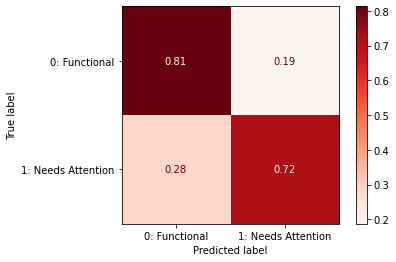

In [98]:
plot_confusion_matrix(lr_3_pipe, X_train, y_train, display_labels=class_names, normalize='true', cmap='Reds');

# Model 2.1: Decision Tree

In [126]:
steps=[('preprocessing', cleaning_pipeline), 
       ('dt', DecisionTreeClassifier(max_depth=20, random_state=42))]

dt_1_pipe = Pipeline(steps)

dt_1_pipe.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('fill_nulls',
                                  FunctionTransformer(func=<function fill_nulls at 0x7fbd545e1ca0>)),
                                 ('impute',
                                  FunctionTransformer(func=<function imputer at 0x7fbd545e1f70>)),
                                 ('transform',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('standard_scale',
                                                                   StandardScaler(),
                                                                   ['amount_tsh',
                                                                    'gps_height',
                                                                    'population',
                                                                    'public_meeting',
                                                                    'permit',
                                                                    'construction_year']),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   ['basin',
                                                                    'region_code',
                                                                    'district_code',
                                                                    'lga',
                                                                    'extraction_type',
                                                                    'management',
                                                                    'payment_type',
                                                                    'water_quality',
                                                                    'quantity',
                                                                    'source',
                                                                    'waterpoint_type'])]))])),
                ('dt', DecisionTreeClassifier(max_depth=20, random_state=42))])

In [127]:
print_cv_scores(dt_1_pipe, X_train, y_train.values.ravel())

/Users/ryanposternak/opt/anaconda3/envs/new-learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Training Accuracy 0.8721436588103255
Cross_Val Accuracy 0.775331088664422
--------------------------------------------------
Training Precision: 0.9138231299911428
Cross_Val Precision: 0.7916815975577438
--------------------------------------------------
Training Recall: 0.7953062040400937
Cross_Val Recall: 0.6899685542330896
--------------------------------------------------
Training F1: 0.8503887234500974
Cross_Val F1: 0.7372997191755726


/Users/ryanposternak/opt/anaconda3/envs/new-learn-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


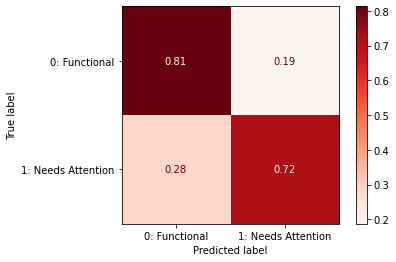

In [123]:
plot_confusion_matrix(lr_3_pipe, X_train, y_train, display_labels=class_names, normalize='true', cmap='Reds');